MNIST 데이터셋 다운로드

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

C:\Users\Yes\AppData\Roaming\Python\Python311\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


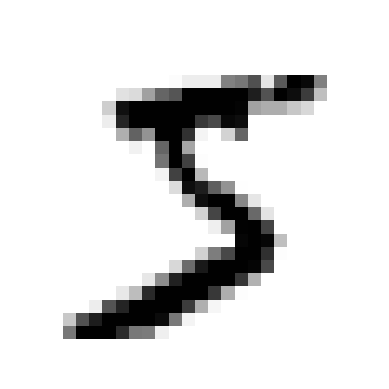

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [4]:
y[0]

'5'

In [5]:
import numpy as np
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000: ], y[:60000], y[60000:]

이진 분류기 훈련

In [7]:
y_train_5 = (y_train == 5) # 5는 True 이고, 다른 모든 숫자는 False
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

성능 측정

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우의 혼동 행렬
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

정밀도와 재현율

In [17]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [18]:
# F1 SCORE
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

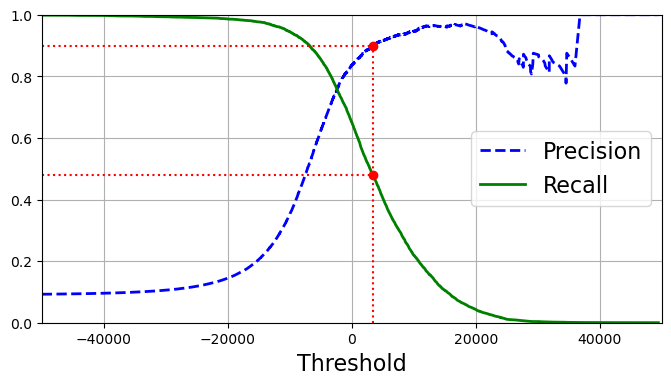

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-",label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

# 정밀도가 90%가 달성되는 지점에서의 재현율과 임계값
recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
threshold_90_percision = thresholds[np.argmax(precisions >= 0.9)]

# 빨강 점과 빨강 점선 그리기
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_percision, threshold_90_percision], [0., 0.9], "r:")# 수직 빨강 점선
plt.plot([-50000, threshold_90_percision], [0.9, 0.9], "r:") # 위 수평 빨간 점선
plt.plot([-50000, threshold_90_percision], [recall_90_precision, recall_90_precision], "r:") # 아래
plt.plot([threshold_90_percision], [0.9], "ro")                 # 위 빨강 점
plt.plot([threshold_90_percision], [recall_90_precision], "ro") # 아래 빨강 점
plt.show()

사이킷런 분류기의 임계값

In [24]:
(y_train_pred == (y_scores > 0)).all()

True

정밀도와 재현율 사이의 관계
- 빨간 점과 빨간 선은 정밀도가 90%가 되는 지점이다.

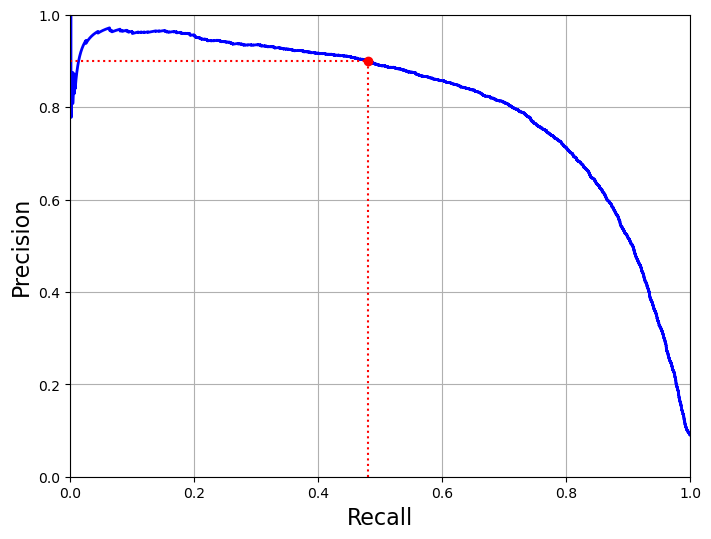

In [25]:
# 정밀도와 재현율 사이의 관계 그래프 그리기
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

# 빨강 점과 빨강 점선 그리기
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:") # 수직 빨강 점선
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:") # 수평 빨강 직선
plt.plot([recall_90_precision], [0.9], "ro") # 빨강 점 좌표
plt.show()

정밀도/재현율 조율 모델 생성

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
print(threshold_90_precision)

3370.0194991439557


In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

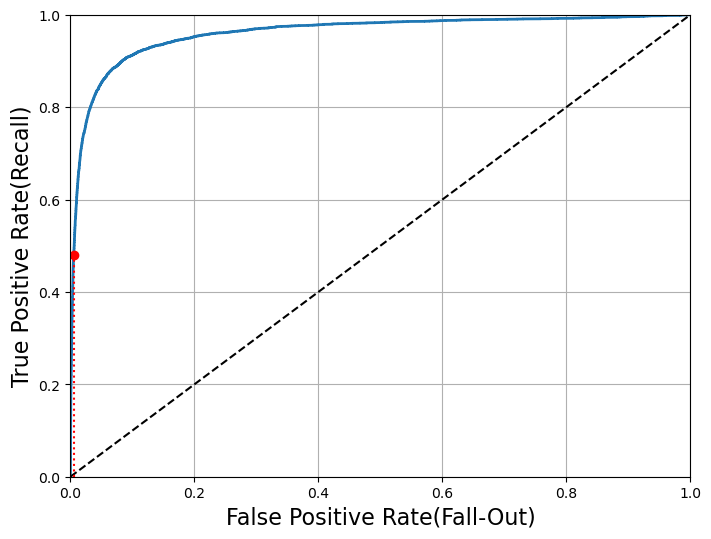

In [32]:
# SGD 분류기 모델의 TPR과 FPR 사이의 관계 그래프 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--") # 대각 접선
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate(Fall-Out)", fontsize = 16)
    plt.ylabel("True Positive Rate(Recall)", fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

# 정밀도가 90%를 넘어설 때의 재현율(TPR, 참 양성 비율)에 해당하는 거짓 양성 비율(FPR)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
# 빨강 점과 원점 사이의 실선 그리기
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro") # 빨강 점
plt.show()

ROC 곡선의 아래 면적 (Area Under the Curve: AUC) 구하기

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

랜덤 포레스트 분류기

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
print(y_probas_forest)

[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 ...
 [0.02 0.98]
 [0.92 0.08]
 [0.94 0.06]]


In [36]:
y_score_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)

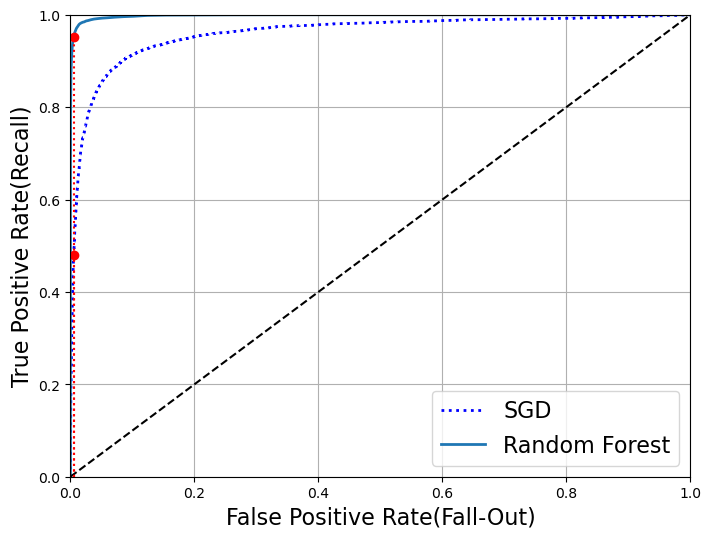

In [37]:
# 랜덤 포레스트 분류기의 ROC 곡선 그리기
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]
plt.figure(figsize=(8, 6))

# 파랑 점 곡선 : SGD 분류기의 ROC 곡선
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
# 파랑 실선 : 랜덤 포레스트 분류기의 ROC 곡선
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:") # 짧은 빨강 수직 점선
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") # 아랫쪽 빨강 수평 점선
plt.plot([fpr_90], [recall_90_precision], "ro") # 아랫쪽 빨강 점
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:") # 윗쪽 빨강 수평 점선
plt.plot([fpr_90], [recall_for_forest], "ro") # 위쪽 빨강 점
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [39]:
roc_auc_score(y_train_5, y_score_forest)

0.9983436731328145

랜덤 포레스트 분류기의 정밀도와 재현율

In [40]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9905083315756169
0.8662608374838591


다중 분류
- SVC(Support vector machine)을 이용하여 일대일(ovo) 전략을 사용한다.

In [42]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # 이제부터 y_train_5 대신, y_train 사용

SVC(gamma='auto', random_state=42)

In [43]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

decision_function() 메서드는 샘플이 각각의 클래스에 대한 점수를 어레이로 반환한다
예를 들어 첫 번째 훈련 샘플에 대한 각 클래스별 점수는 다음과 같다.

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

[[ 2.81585438  7.09167958  3.82972099  0.79365551  5.8885703   9.29718395
   1.79862509  8.10392157 -0.228207    4.83753243]]


넘파이의 argmax() 함수는 최댓값이 위치한 인덱스를 반환한다.

In [45]:
np.argmax(some_digit_scores)

5

In [46]:
# 5번 인덱스에 해당하는 클래스를 알아보기 위해 사용된 클래스를 확인한다.
svm_clf.classes_ 

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [47]:
svm_clf.classes_[5]

5

일대다 방식 활용
- SVC는 기본적으로 일대일 ovo 방식으로 다항 클래스 분류를 진행한다.
- ovr 방식을 사용해서 일대다 방식으로 변경할 수 있다.

In [51]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000]) # 첫 1000개의 훈련 샘플만을 이용한 일대다 방식 진행

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42))

In [52]:
ovr_clf.predict([some_digit]) # 첫 번째 샘플을 5라고 예측한다.

array([5], dtype=uint8)

아래의 코드는 일대다 방식에 사용된 svc 모델의 수가 10개임을 확인해준다.
- estimators_메서드: 일대다 방식에 사용된 예측기, 여기서는 SVC 모델을 저장한다.

In [53]:
len(ovr_clf.estimators_)

10

SGDClassifier와 RandomForestClassifier 분류기
- 두 모델은 다중 클래스 분류를 기본으로 지원하기에, ovo, ovr 방식을 고민할 필요가 없다.
- 아래 코드는 SGD 분류기를 이용하여 10개 클래스 전체를 대상으로 분류를 진행한다.

In [54]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [55]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

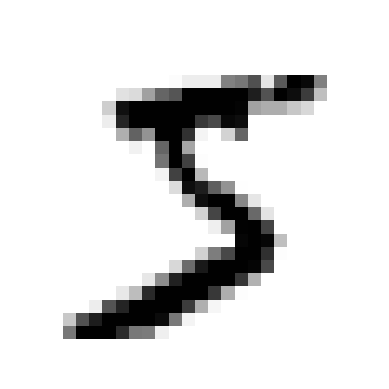

In [57]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

plot_digit(some_digit)

첫째 샘플에 대한 10개 클래스별 예측 점수는 다음과 같이 3번 인덱스에 위치한 값이 가장 크다.

In [58]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

아래 코드는 3-겹 교차 검증을 이용하여 SGD 모델의 성능을 정확도를 기준으로 측정한다.
이진 분류의 경우와는 달리, 여기서는 정확도를 충분히 신뢰할 수 있다.
- 각 숫자의 비율이 비슷하기 때문

In [59]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [60]:
# 표준화 축적 조정 전처리 진행 후 SGD 분류기 훈련
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

에러 분석
- 이제 좋은 모델을 하나 찾았다고 가정한 후, 모델의 성능을 향상시키는 방법을 소개한다.
    - 좋은 모델을 구하기 위한 하이퍼파라미터 튜닝 등은 그리드 탐색, 랜덤 탐색 등을 이용한다.
- 어떤 방법으로 모델의 성능을 향상시켜야 하는가는 경유에 따라 다르다.
    - 여기서는 오차 행렬을 이용하여 분류 오류의 발생 원인을 찾고, 어떻게 해결할 수 있는지를 살펴본다.
    - 아래 코드는 SGD 분류기를 3겹 교차 검증으로 훈련시킨 후 오차 행렬을 계산한다.
    - 10개의 클래스를 대상으로 진행하였기에, 10x10 행렬 모양의 2차원 어레이가 생성된다.
        - 행: 0부터 9까지의 실제 레이블
        - 열: 0부터 9까지의 예측 레이블
    - 예를 들어, 실제로 0번을 담은 사진에 대한 예측은 0번 행을 보면 된다.
    - 그러면, 0으로 제대로 예측된 이미지는 5577개로, 1로 잘못 예측된 이미지는 0개, 2로 잘못 예측된 이미지는 22개 등이 된다.
    

In [61]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

위 오차 행렬을 흑백 이미지로 표현하면 아래과 같다.
- 오차 행렬에 사용된 숫자가 클 수록 해당 칸의 색은 상대적으로 밝아진다.
    - 대각선: 대부분의 숫자 이미지를 제대로 예측했다는 의미
    - 숫자 5의 경우 상대적으로 어둡다.
        - 숫자 5 이미지가 상대적으로 적거나, 다룬 숫자에 비해 숫자 5에 대한 분류기의 정확도가 떨어진다는 의미이다.

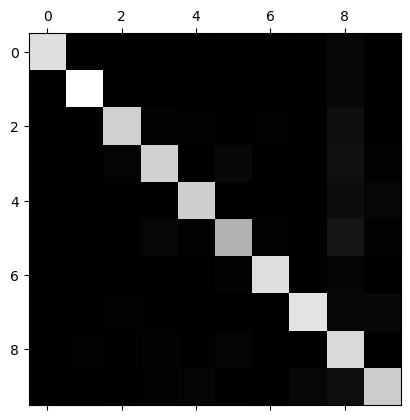

In [62]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

오차율 행렬 활용
- 숫자별 오차율을 계산해서 이미지로 표현하면 보다 정확한 이류를 알 수 있다.
- 이를 위해 각 숫자별 이미지 개수를 확인한 후, 다음에 숫자별 오차율로 이뤄진 행렬을 생성한다.
    - 즉, 오차 행렬을 숫자별 이미지 총 개수로 나눈다.

In [65]:
row_sums = conf_mx.sum(axis=1, keepdims=True) # 숫자별 총 이미지 개수
norm_conf_mx = conf_mx / row_sums # 숫자별 오차율 행렬

오차율 행렬을 이미지로 표현하면 다음과 같다.
- 정확하게 예측된 부분을 무시하기 위해 대각선은 0으로 채워야 오류가 있는 칸이 선명하게 드러난다.
- 5번 행, 8번 열이 가장 밝다: 숫자 5 이미지를 8로 잘못 예측한 비율이 가장 높다는 의미이다.
- 5를 3으로 또는 3을 5로 혼동한 경우도 많다.

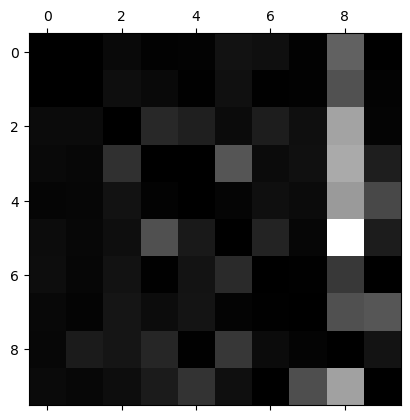

In [66]:
np.fill_diagonal(norm_conf_mx, 0) # 대각선을 0으로 채우기
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

plt.show()

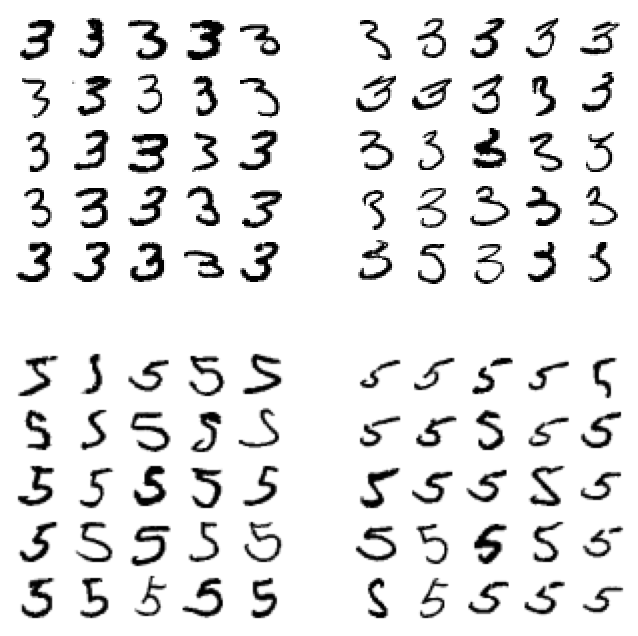

In [71]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 3을 3으로 예측한 샘플들
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 3을 5으로 예측한 샘플들
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 5를 3으로 예측한 샘플들
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # 5를 5로 예측한 샘플들

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)  # 이미지 상단 왼편
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)  # 이미지 상단 오른편
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)  # 이미지 하단 왼편
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)  # 이미지 하단 오른편

다중 레이블 분류
- 하나의 샘플에 대해 한 개의 클래스가 아닌 여러 개의 클래스를 예측하는 분류이다.
- 예를 들어, 하나의 사진에 지정된 세 사람의 인물이 포함되어 있는지 여부를 예측하고 길이가 3인 어레이로 반환하라고 할 수 있다.
- 지정된 세 사람이 앨리스, 밥, 찰리라면, 다중 레이블 분류기는 아래와 같은 예측값을 반환해야 한다.
    - [True, False, True]
        - 위 결과에 따르면 앨리스와 찰리는 사진에 있지만, 밥은 없다고 예측된다.
- 아래 코드는 MNIST 이미지 샘플 각각에 대해 이미지가 가리키는 숫자를 예측하는 것 대신, 이미지가 나타내는 수가 홀수인지 여부와 7보다 크거나 같은지 여부를 함께 예측한다.

In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

다중 레이블 분류
- 다중 레이블 분류기를 평가하는 방법은 모델과 목적에 따라 달라진다.
- 예를 들어, 각 레이블의 F1 점수를 구하고, 레이블에 대한 가중치를 적용한 평균 점수 계산
    - 가중치 예제: 타깃 레이블에 속한 샘플 수인 지지도(supprot) 즉, 샘플 수가 많은 클래스의 가중치를 보다 크게 줄일 수 있다.
- 아래 코드는 모든 레이블의 중요도가 동일하다고 가정하며, 위 KNN 모델의 F1 점수를 계산한다.

In [73]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

다중 출력 분류
- 다중 출력 다중 클래스 분류라고도 불린다.
- 다중 레이블 분류에서 한 레이블이 이진 클래스가 아닌 다중 클래스를 대상으로 예측하는 분류이다.

다중 출력 분류 예제
- 예제: 이미지에서 잡음을 제거하는 시스템
    - 다중 레이블: 각각의 픽셀에 대해 레이블을 예측해야 한다.
    - 다중 클래스: 각각의 픽셀에서 예측하는 레이블이 0부터 255중 하나이다.

아래 코드는 MNIST 데이터셋에 포함된 모든 샘플에 잡음을 추가한다.
단, 훈련 세트와 테스트 세트에 서로 다른 잡음을 이용한다.

In [74]:
# MNIST 훈련 세트의 모든 샘플에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

# MNIST 테스트 세트의 모든 샘플에 잡음을 추가한다.
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# 레이블은 사진 원본
y_train_mod = X_train
y_test_mod = X_test

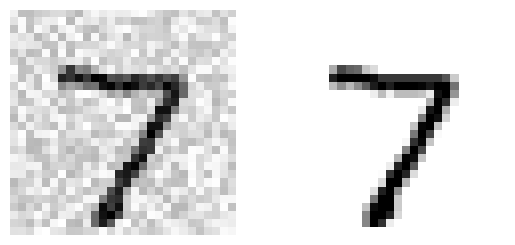

In [75]:
some_index = 0 # 0번 인덱스

plt.subplot(121); plot_digit(X_test_mod[some_index]) # 잡음 추가된 이미지
plt.subplot(122); plot_digit(y_test_mod[some_index]) # 원본 이미지

plt.show()

In [76]:
# KNN 모델을 이용하여 다중 출력 모델을 훈련한다.
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

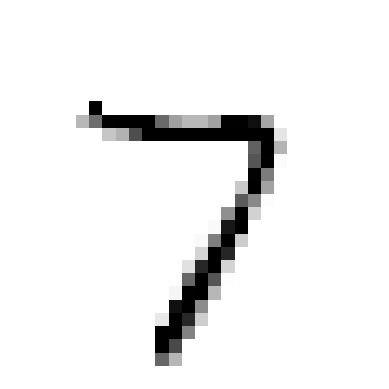

In [77]:
# 훈련된 모델이 테스트 세트 첫 번째 샘플에 대해 예측한 이미지는 잡음을 많이 제거한 이미지이다.
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plot_digit(clean_digit)